# Gaussian Processes

skorch supports integration with the fantastic [GPyTorch](https://gpytorch.ai/) library. GPyTorch implements various Gaussian Process (GP) techniques on top of PyTorch.

GPyTorch adopts many patterns from PyTorch, thus making it easy to pick up for seasoned PyTorch users. Similarly, the skorch GPyTorch integration should look familiar to seasoned skorch users. However, GPs are a different beast than the more common, non-probabilistic machine learning techniques. It is important to understand the basic concepts before using them in practice.

This notebook is not the place to learn about GPs in general, instead a basic understanding is assumed. If you're looking for an introduction to probabilistic programming and GPs, here are some pointers:

- The GPyTorch [documentation](https://docs.gpytorch.ai/en/stable/)
- The book [Gaussian Processes for Machine Learning](http://gaussianprocess.org/gpml/chapters/) by Carl Edward Rasmussen and Christopher K. I. Williams
- The lecture series [Probabilistic Machine Learning](https://www.youtube.com/playlist?list=PL05umP7R6ij1tHaOFY96m5uX3J21a6yNd) by Philipp Hennig

Below, we will show you how to use skorch for Gaussian Processes through GPyTorch. We assume that you are familiar with how skorch and PyTorch work and we will focus on how using GPs differs from using non-probabilistic deep learning techniques with skorch.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/Gaussian_Processes.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/Gaussian_Processes.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

If you haven't already, you should install GPyTorch, since it is not installed automatically after installing skorch:

```bash
# using pip
pip install -U gpytorch
# using conda
conda install gpytorch -c gpytorch
```

In [1]:
! [ ! -z "$COLAB_GPU" ] && pip install torch skorch gpytorch

## Table of contents

* [Exact Gaussian Process Regression](#Exact-Gaussian-Process-Regression)
  * [Simple example: sine curve](#Simple-example:-sine-curve)
  * [GP regression with real world data](#Regression-with-real-world-data)
* [Stochastic Variational GP Regression](#Stochastic-Variational-GP-Regression)
* [Classification](#Classification)
  * [Binary classification](#Binary-classification)
  * [Multiclass classification](#Multiclass-Classification)

## Imports

In [2]:
import math
import os
import urllib.request

In [3]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

In [4]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
plt.style.use('seaborn')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

# Exact Gaussian Process Regression

GPyTorch implmenets different methods to solve GPs. The most basic form is to use exact solutions. Variational GPs are described further below.

## Simple example: sine curve

The "Hello world" of GPs is predicting a sine curve with Gaussian noise added on top. We will start with this example.

### Creating the data

First we synthesize our data. For training, we use a sine curve with Gaussian noise added on top. For validation, we just use the sine without noise, assuming this is the underlying ground truth. To make it difficult for the model, the training data will only contain very few data points for now.

In [5]:
sampling_frequency = 0.5
X_train = torch.arange(-8, 9, 1 / sampling_frequency).float()
y_train = torch.sin(X_train) + torch.randn(len(X_train)) * 0.2

In [6]:
X_valid = torch.linspace(-10, 10, 100)
y_valid = torch.sin(X_valid)

As you can see below, there is a slight hint of periodicity in the training data but it could also just be noise.

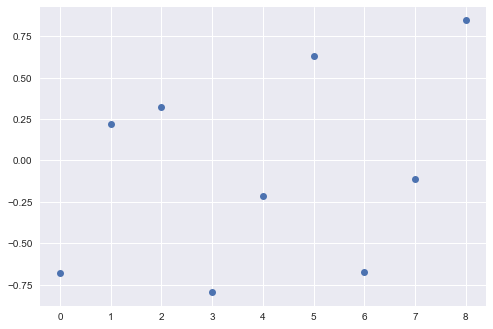

In [7]:
plt.plot(y_train, 'o')

### Defining the module

As usual with PyTorch, the core of your modeling approach is to define the module. In our case, instead of subclassing `torch.nn.Module`, we subclass `gpytorch.models.ExactGP` (which itself is a subclass of `torch.nn.Module`), since we want to do exact GP. As always, we need to define our own `__init__` method (don't forget to call `super().__init__`) and our own `forward` method.

In [8]:
class RbfModule(gpytorch.models.ExactGP):
    def __init__(self, X, y, likelihood, noise_init=None):
        super().__init__(X, y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Again, we don't want to go into too much details about GPs or GPyTorch. The important ingredients here are the _mean function_ and the _kernel function_. As the name suggests, the mean function is only there to determine the means of the Gaussian distribution. The kernel function is used to calculate the covariance matrix of the data points. Together, means and covariance matrix are sufficient to define a Gaussian distribution.

For the mean function `gpytorch.means.ConstantMean` will often do. Choosing the correct kernel, however, is where it gets interesting. This kernel should be chosen wisely so as to fit the problem as best as possible. The correct choice here is as crucial as choosing the correct Deep Learning architecture &mdash; when you choose an RNN for an image classification problem, you will have little luck. That being said, a good start is often to use the `RBFKernel` and then iterate from there. That's why we use the RBF for our toy example.

The output of the `forward` method should always be a `gpytorch.distributions.MultivariateNormal` for `ExactGP`. It represents the prior latent distribution conditioned on the input data. The posterior is computed by applying a likelihood, which is `gpytorch.likelihoods.GaussianLikelihood` by default for GP regression.

### skorch `GPRegressor`

Now let's define our skorch model. For this, we import `GPRegressor` and initialize it in much the same way as we would a `NeuralNet`.

In [9]:
from skorch.probabilistic import GPRegressor
from skorch.utils import futureattr

In [10]:
gpr = GPRegressor(
    RbfModule,
    module__X=X_train if DEVICE == 'cpu' else X_train.cuda(),
    module__y=y_train if DEVICE == 'cpu' else y_train.cuda(),
    module__likelihood=futureattr('likelihood_'),

    optimizer=torch.optim.Adam,
    lr=0.1,
    max_epochs=20,
    device=DEVICE,
    batch_size=-1,
)

As you can see, we pass the `RbfModule` defined above as the first argument, as we always do. We also define the optimizer, learning rate (`lr`) and device as usual. We could pass our own `likelihood` argument, but since we use the default likelihood, we don't need to do that.

There are a few peculiarities that need explaining. First, we can see that we pass our training data directly to the module using `module__X=X_train` and `module__y=y_train`. The reason is that the `ExactGP` needs the training data to be initialized, before even fitting. So this is a major difference to normal DL that you need to be aware of. Since this data is passed directly to the GPyTorch module, it also means that `X` and `y` need to be torch tensors here &mdash; this wouldn't work with numpy arrays.

<div class="alert alert-block alert-info">
    <b>Info:</b>
    You might be weary of passing the training data as initialization parameters, especially if you have a lot of data, because it means that a <i>reference</i> to the data will be stored on the <code>GPRegressor</code>. However, the GPyTorch module will store a reference to the data anyway, so this is not really a concern. If you want to avoid this issue completely, take a look at the variational method described further below.
</div>

Next, you see that we have this strange line `module__likelihood=futureattr('likelihood_')`. What does that mean? It means that the module will be passed the likelihood at initialization, which is a required argument. Since the instantiated likelihood doesn't exist yet, we cannot reference it directly at this point. That's why we use skorch's `futureattr`, which tells skorch that this attribute will exist in the future. The first argument to this function is the name of that attribute. Take care that this should be `'likelihood_'` with an underscore at the end, not `'likelihood'`. As always in skorch, the trailing underscore signifies that the object is instantiated, which is exactly what we need here.

We could of course instantiate the likelihood in advance, which would allow us to reference it (an example is shown further below). However, if we do this, we cannot change any attribute of the likelihood later (say, when we do a grid search), as this requires to re-instantiate the likelihood.

Finally, one oddity you might have noticed is `batch_size=-1`. -1 is a placeholder that means: take all the data at once, i.e. don't use batching. The reason for this is that the exact solution requires all data at once, it does not work on batches. If you need to use batches (say, you don't have enough GPU memory to fit all your data), you have to use variational GPs, as shown later in the notebook.

### Sampling

At this point, we can already show a new feature that is available thanks to GPs. They allow us to sample from the underlying distribution, conditioned on our data, even though we have not even trained the model. To do this, we initialize the `GPRegressor` by calling `initialize()` and then use the `sample` method. The first argument to `sample` is the data to condition on, in this case the training data, and the second argument is the number of samples to draw.

We plot the result next to the ground truth and the training data for comparison.

/home/vinh/anaconda3/envs/skorch/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


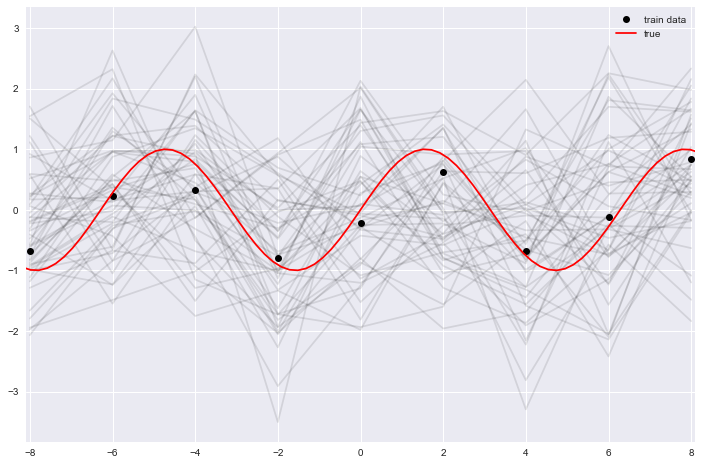

In [11]:
gpr.initialize()

# According to the GPyTorch docs, the fast_pred_samples context manager
# uses a special method to accelerate sampling, see
# https://docs.gpytorch.ai/en/stable/settings.html?highlight=fast_pred_samples#gpytorch.settings.fast_pred_samples
with gpytorch.settings.fast_pred_samples():
    samples = gpr.sample(X_train, 50)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, samples.T, color='k', alpha=0.1)
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, 'r', label='true')
ax.set_xlim([-8.1, 8.1])
ax.legend();

It can often be wise to plot a couple of samples _before_ starting a lengthy training process. These samples can be compared to the underlying data to see if the chosen model looks reasonable _a priori_. If the data looks very different from the smaples, it means it could not result from the assumed distribution, so no matter how much you train, your model will never fit your data well. In such a case, you probably need to find a better kernel function.

### Fitting

As always, to train the model, we call the `fit` method and pass the training data and targets as arguments:

In [12]:
gpr.fit(X_train, y_train)

Re-initializing likelihood.
Re-initializing module because the following parameters were re-set: X, likelihood, y.
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        1.2771  0.0050
      2        1.2535  0.0034
      3        1.2316  0.0499
      4        1.2110  0.0039
      5        1.1933  0.0052
      6        1.1774  0.0040
      7        1.1631  0.0047
      8        1.1509  0.0097
      9        1.1409  0.0061
     10        1.1321  0.0048
     11        1.1245  0.0060
     12        1.1183  0.0054
     13        1.1133  0.0049
     14        1.1090  0.0042
     15        1.1052  0.0057
     16        1.1022  0.0061
     17        1.0998  0.0062
     18        1.0976  0.0080
     19        1.0957  0.0056
     20        1.0942  0.0101


<class 'skorch.probabilistic.GPRegressor'>[initialized](
  module_=RbfModule(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  ),
)

<div class="alert alert-block alert-info">
    <b>Info:</b>
    For GP regression, skorch does <i>not</i> perform a train/valid split by default. This is why you only see the train loss here, not the validation loss as usual. The reason is that a random split is most often not appropriate for GP regression. E.g. when you deal with a time series, random splitting would result in data leakage. Therefore, if you want validation scores, it is probably best to implement your own <code>train_split</code> or use <code>skorch.helper.predefined_split</code> if you already have split your data beforehand (see the example further below).
</div>

### Analyzing the trained model

Now that our model is trained, we can repeat the sampling process from above. As you can see, the samples fit the data much better now.

/home/vinh/anaconda3/envs/skorch/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


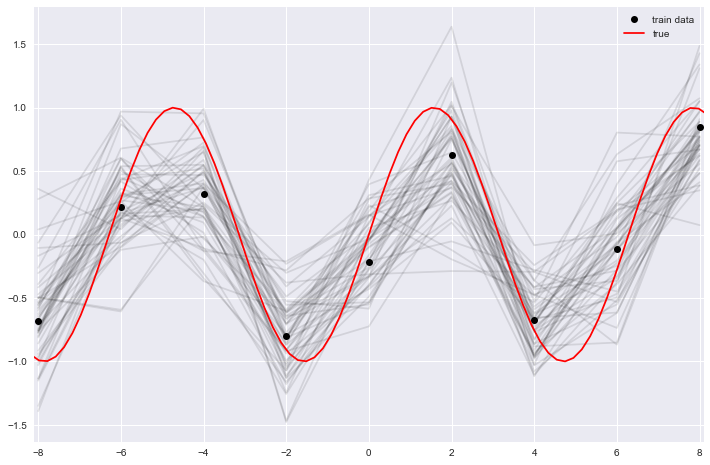

In [13]:
with gpytorch.settings.fast_pred_samples():
    samples = gpr.sample(X_train, 50)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, samples.T, color='k', alpha=0.1)
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, 'r', label='true')
ax.set_xlim([-8.1, 8.1])
ax.legend();

Since the model learns a real distribution, not just a point prediction as is most often the case for Deep Learning, we can use the distribution to give us confidence intervals. To do this, we can pass `return_std=True` to the `predict` call. This will return one standard deviation for the given data, which we can add/subtract from our prediction to get upper/lower confidence bounds:

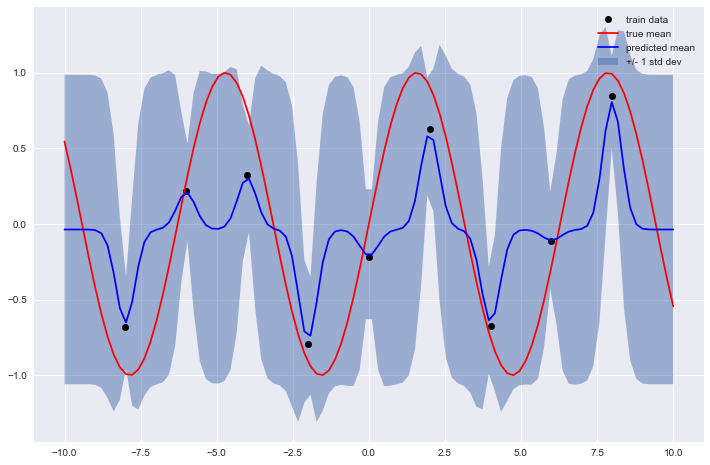

In [14]:
y_pred, y_std = gpr.predict(X_valid, return_std=True)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, color='red', label='true mean')
ax.plot(X_valid, y_pred, color='blue', label='predicted mean')
ax.fill_between(X_valid, y_pred - y_std, y_pred + y_std, alpha=0.5, label='+/- 1 std dev')
ax.legend()

As you can see, the confidence bounds are quite wide most of the time. Only at the training data points is the model more confident. This is exactly what we should expect: At the points where the model has seen some data, it is more confident, but between data points, it is less so.

### More data

Below, we increase the sampling frequency from our sine function and train the same model again to show how a well fit model looks like.

In [15]:
sampling_frequency = 2
X_train = torch.arange(-8, 9, 1 / sampling_frequency).float()
y_train = torch.sin(X_train) + torch.randn(len(X_train)) * 0.2

In [16]:
gpr = GPRegressor(
    RbfModule,
    module__X=X_train if DEVICE == 'cpu' else X_train.cuda(),
    module__y=y_train if DEVICE == 'cpu' else y_train.cuda(),
    module__likelihood=futureattr('likelihood_'),

    optimizer=torch.optim.Adam,
    lr=0.1,
    max_epochs=20,
    batch_size=-1,
    device=DEVICE,
)
gpr.fit(X_train.reshape(-1, 1), y_train)

  epoch    train_loss     dur
-------  ------------  ------
      1        1.1546  0.0052
      2        1.1007  0.0046
      3        1.0429  0.0035
      4        0.9834  0.0035
      5        0.9219  0.0056
      6        0.8580  0.0056
      7        0.7923  0.0065
      8        0.7254  0.0040
      9        0.6578  0.0056
     10        0.5899  0.0040
     11        0.5224  0.0058
     12        0.4561  0.0043
     13        0.3922  0.0045
     14        0.3318  0.0036
     15        0.2762  0.0037
     16        0.2269  0.0063
     17        0.1852  0.0041
     18        0.1524  0.0050
     19        0.1289  0.0052
     20        0.1143  0.0090


<class 'skorch.probabilistic.GPRegressor'>[initialized](
  module_=RbfModule(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  ),
)

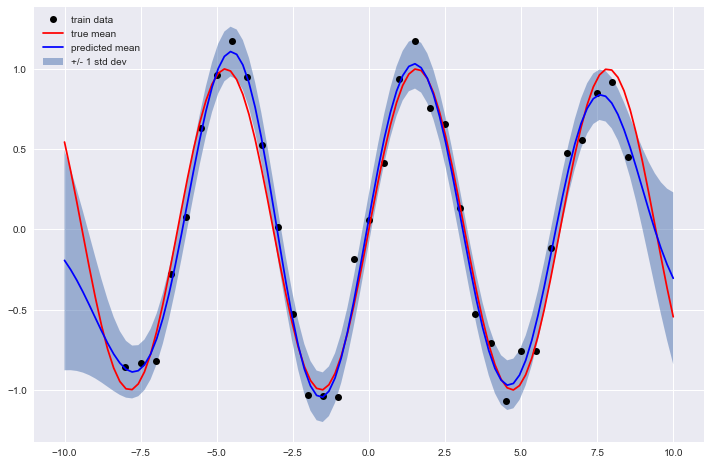

In [17]:
y_pred, y_std = gpr.predict(X_valid, return_std=True)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, color='red', label='true mean')
ax.plot(X_valid, y_pred, color='blue', label='predicted mean')
ax.fill_between(X_valid, y_pred - y_std, y_pred + y_std, alpha=0.5, label='+/- 1 std dev')
ax.legend()

Here we can see that the confidence intervals are much narrower than above, even between data points. This means that the model is quite confident in _interpolating_ between data points. Notice, however, that the confidence bounds increase considerably at the left and right end, i.e. at values below and above the training data. This means that the model is less confident in _extrapolating_.

### Confidence region

Another way skorch implements to quickly get the confidence interval is through the `confidence_region` method. This mirrors the method by the same name in GPyTorch. By default, it returns the lower and upper bound for 2 standard deviations, but this can be changed through the `sigmas` argument.

In [18]:
lower, upper = gpr.confidence_region(X_valid, sigmas=2)

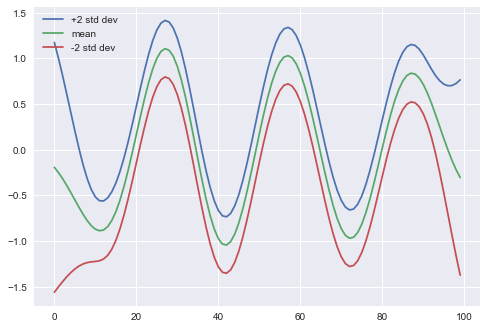

In [19]:
plt.plot(upper, label='+2 std dev')
plt.plot(y_pred, label='mean')
plt.plot(lower, label='-2 std dev')
plt.legend();

## Regression with real world data

So far, we have only worked with toy data. To show how to work with real world data, we will reproduce an example from the GPyTorch docs:

https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Spectral_Delta_GP_Regression.html

This dataset contains the "BART ridership on the 5 most commonly traveled stations in San Francisco". "BART" is the "Bay Area Rapid Transit", i.e. public transit system in the San Francisco bay area.

For more details, please consult the link.

### Getting the data

First of all we need to download the data. This only needs to be done if the data has not already been downloaded.

In [20]:
if not os.path.isfile('../BART_sample.pt'):
    print('Downloading BART sample dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1A6LqCHPA5lHa5S3lMH8mLMNEgeku8lRG', '../BART_sample.pt')
    
train_x, train_y, test_x, test_y = torch.load('../BART_sample.pt', map_location=DEVICE)

We need to scale the input data a bit, following the tutorial:

In [21]:
train_x_min = train_x.min()
train_x_max = train_x.max()

X_train = train_x - train_x_min
X_valid = test_x - train_x_min

The target data also needs to be scaled. However, contrary to the tutorial, we will use sklearn's `StandardScaler` for this. Although it performs the same transformation as in the tutorial, it allows us to easily inverse transform the targets back to their original scale, which will be useful later.

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
# We need to transpose here because the target data is sequence x sample
# but we want to scale over the samples, not over the sequence.
y_scaler = StandardScaler().fit(train_y.T)
y_train = torch.from_numpy(y_scaler.transform(train_y.T).T).float()
y_valid = torch.from_numpy(y_scaler.transform(test_y.T).T).float()

In [24]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

torch.Size([5, 1440, 1]) torch.Size([5, 1440]) torch.Size([5, 240, 1]) torch.Size([5, 240])


### Defining the module

The module is effectively the same as in the tutorial.

In [25]:
class SpectralDeltaGP(gpytorch.models.ExactGP):
    def __init__(self, X, y, likelihood, num_deltas, noise_init=None):
        super(SpectralDeltaGP, self).__init__(X, y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.SpectralDeltaKernel(
            num_dims=X.size(-1),
            num_deltas=num_deltas,
        )
        self.covar_module = gpytorch.kernels.ScaleKernel(base_covar_module)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Defining the GPRegressor

Here we show an example of passing an already initalized _likelihood_ to `GPRegressor`. skorch is smart enough to recognize this and will not re-initialize the likelihood, except if you want to change its parameters. Since we already have an iniatlized likelihood, we can pass this to `module__likelihood`, thus avoiding the need to use `futureattr('likelihood_')` as earlier. Don't forget to also pass the likelihood to `GPRegressor` itself.

<div class="alert alert-block alert-warning">
    <b>Warning:</b>
    If you use an already initialized likelihood like this, it will be re-used even if the model is fitted more than once. E.g. when you call <code>fit</code> on the model below and later you call <code>fit</code> again, the model is re-initialized as expected (e.g. creating a new module) but <i>not</i> the likelihood, which will already be trained at that point. You should thus only use an already initialized likelihood if you know exactly that this problem will not matter for you.
</div>

In [26]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-11))
likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
likelihood.noise = 1e-2

gpr = GPRegressor(
    SpectralDeltaGP,
    module__num_deltas=1500,
    module__likelihood=likelihood,
    module__X=X_train if DEVICE == 'cpu' else X_train.cuda(),
    module__y=y_train if DEVICE == 'cpu' else y_train.cuda(),

    likelihood=likelihood,

    optimizer=torch.optim.Adam,
    lr=2e-4,
    max_epochs=50,
    batch_size=-1,
    device=DEVICE,
)

Again, as explained above, we additionally need to pass `X` and `y` to the module and we need to set the batch size to -1, since we still deal with exact GPs.

### Training the model

In [27]:
# This context manager ensures that we dont try to use Cholesky. This is
# in following with the tutorial.
with gpytorch.settings.max_cholesky_size(0):
    gpr.fit(X_train, y_train)

  epoch    train_loss     dur
-------  ------------  ------
      1        4.1653  1.9962
      2        2.4631  1.6211
      3        2.0228  2.1956
      4        1.5854  1.6171
      5        1.3913  1.6186
      6        1.3264  1.6360
      7        1.2460  2.1825
      8        1.1659  1.6436
      9        1.1333  1.6209
     10        1.0871  1.6225
     11        1.0358  1.6211
     12        1.0098  1.7270
     13        1.0004  1.6268
     14        0.9511  1.6252
     15        0.8989  1.6284
     16        0.8544  1.8329
     17        0.8507  1.6421
     18        0.8264  1.6465
     19        0.8211  1.8351
     20        0.8091  2.1725
     21        0.7747  1.7574
     22        0.7302  1.7511
     23        0.7247  1.8264
     24        0.6784  2.2255
     25        0.6740  1.7296
     26        0.6957  1.8188
     27        0.6927  1.7509
     28        0.6817  1.8138
     29        0.6509  2.3264
     30        0.6735  1.7548
     31        0.6361  1.7677
     32   

### Analyzing the trained model

Again, let's plot the predictions and the standard deviations for our 5 time series and see how well the model learned.

In [28]:
%%time
y_pred, y_std = gpr.predict(X_valid, return_std=True)

CPU times: user 28.6 s, sys: 6.44 s, total: 35.1 s
Wall time: 8.76 s


Here we make use of our [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale the targets back to their original scale. Remember to also scale the standard deviations.

In [29]:
y_pred = y_scaler.inverse_transform(y_pred.T).T
y_std = y_scaler.inverse_transform(y_std.T).T

In [30]:
def plot_bart(ax, X_train, y_train, X_valid, y_valid, y_pred, y_std):
    lower = y_pred - y_std
    upper = y_pred + y_std

    ax.plot(X_train, y_train, 'k*', label='train')
    ax.plot(X_valid, y_valid, 'r*', label='valid')
    # Plot predictive means as blue line
    ax.plot(X_valid, y_pred, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_valid, lower, upper, alpha=0.5, label='+/- 1 std dev')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.set_ylabel('Passenger Volume', fontsize=16)
    ax.set_xlabel('Hours', fontsize=16)
    ax.set_xticks([])

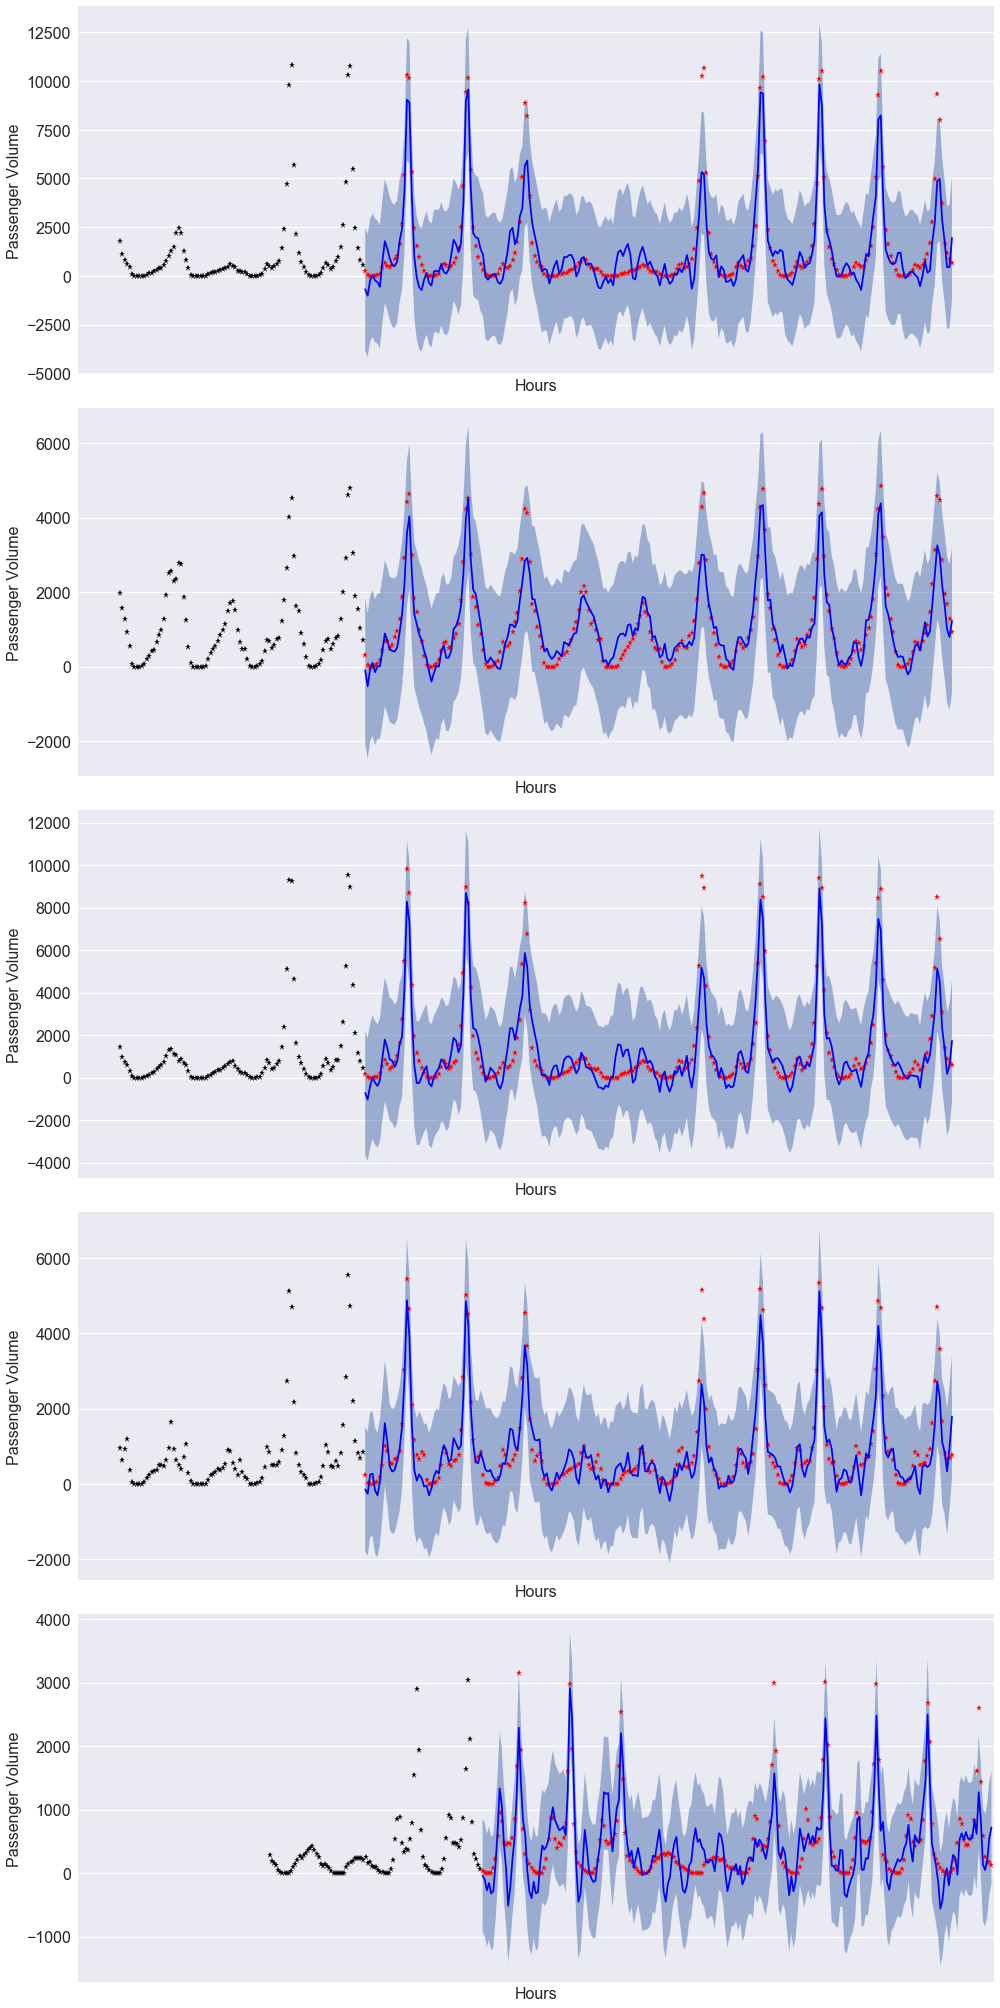

In [31]:
fig, axes = plt.subplots(5, figsize=(14, 28))
y_train_unscaled = y_scaler.inverse_transform(y_train.T).T
y_valid_unscaled = y_scaler.inverse_transform(y_valid.T).T
for i, ax in enumerate(axes):
    plot_bart(
        ax,
        X_train[i, -100:, 0],
        y_train_unscaled[i, -100:],
        X_valid[i, :, 0],
        y_valid_unscaled[i],
        y_pred[i],
        y_std[i],
    )

plt.xlim([1250, 1680])
plt.tight_layout()

### Retrieving the covariance

If you have worked with sklearn's [`GaussianProcessRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor) in the past, you might know that it supports a way to retrieve the covariance by calling `regressor.predict(X, return_cov=True)`. This is not supported by skorch's `GPRegressor`.

It is, however, possible to use the `forward_iter` method to get the covariance indirectly. This will return the posterior distribution, which has a `covariance_matrix` attribute. Below, we show how to use this to plot the covariance of the first 20 data points of the first time series.

In [32]:
posterior = next(gpr.forward_iter(X_valid))

In [33]:
posterior

MultivariateNormal(loc: torch.Size([5, 240]))

In [34]:
posterior.covariance_matrix.shape

torch.Size([5, 240, 240])

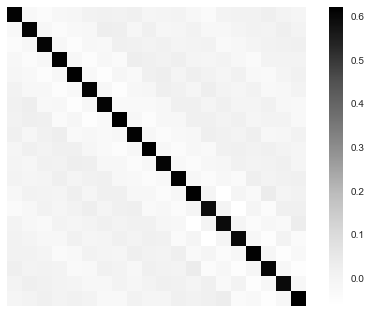

In [35]:
plt.imshow(posterior.covariance_matrix[0, :20, :20].detach().numpy())
plt.colorbar()
plt.grid(None)
plt.axis('off');

## Stochastic Variational GP Regression

So far, we have dealt with exact GP regression. As the name suggest, this method is exact instead of relying on approximations. There are a few disadvantages, however. Without going into details, exact solutions are not possible for most non-Gaussian distributions, so if you want to use another distribution, you cannot use exact GPs. Also, using variational GPs with GPyTorch allows us to use batching, so it's really the only way to larger datasets.

For this part of the notebook, we rely on the following GPyTorch tutorial:

https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html

### Getting the data

Again, we download an real world dataset (if it hasn't been downloaded already) and perform some minor preprocessing first, following the tutorial.

In [36]:
from scipy.io import loadmat

In [37]:
if not os.path.isfile('../elevators.mat'):
    print('Downloading \'elevators\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1jhWL3YUHvXIaftia4qeAyDwVxo6j1alk', '../elevators.mat')

In [38]:
data = torch.Tensor(loadmat('../elevators.mat')['data'])
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

# train/valid split
train_n = int(math.floor(0.8 * len(X)))
X_train = X[:train_n, :].contiguous()
y_train = y[:train_n].contiguous()
X_valid = X[train_n:, :].contiguous()
y_valid = y[train_n:].contiguous()

In [39]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

torch.Size([13279, 18]) torch.Size([13279]) torch.Size([3320, 18]) torch.Size([3320])


As you can see, we deal with a bigger dataset now than before. Thankfully, we will be able to use batching to avoid potential memory issues.

### Defining the module

This time around, since we don't use exact GPs, we actually need to subclass from GPyTorch's `ApproximateGP`. Additionally, we need to define a variational strategy. For more details, please refer to the corresponding [GPyTorch tutorial](https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html).

Apart from that, we have to define the mean function, the kernel function, and the output distribution, as usual.

In [40]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

In [41]:
class VariationalModule(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Defining the GPRegressor

As previously, we use skorch's `GPRegressor`, given that we deal with a regression problem. On top of that, this time around we will see how to obtain validation scores using a predefined split. Specifically, we are interested in the mean absolute error. Fortunately, skorch provides all the tools to make this easy.

In [42]:
from skorch.callbacks import EpochScoring
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from sklearn.metrics import mean_absolute_error

First we define the train/validation split using the validation data we split off earlier. Note that the input to `predefined_split` should be a `Dataset`.

In [43]:
train_split = predefined_split(Dataset(X_valid, y_valid))

Second, we want to calculate the mean absolute error on the validation data, which we can achieve by using skorch's `EpochScoring` and the `mean_absolute_error` metric from sklearn.

In [44]:
# the "name" argument is only important for printing the output
mae_callback = EpochScoring(mean_absolute_error, name='valid_mae')

Next we initialize the `GPRegressor` using the module, train split, and callback we just defined:

In [45]:
gpr = GPRegressor(
    VariationalModule,
    module__inducing_points=X_train[:500]if DEVICE == 'cpu' else X_train.cuda()[:500],

    criterion=gpytorch.mlls.VariationalELBO,
    criterion__num_data=len(y_train),

    optimizer=torch.optim.Adam,
    lr=0.01,
    batch_size=1024,
    train_split=train_split,
    callbacks=[mae_callback],
    device=DEVICE,
)

Some notes:

- Our variational strategy requires some data as "inducing points", which we pass to the module as `module__inducing_points`. We will use 500 data points from our training data for this.
- We need to pick a criterion to match our variational GP, in this case `VariationalELBO`.
- We can now take advantage of batching by setting `batch_size=1024` instead of -1.

### Fitting

In [46]:
gpr.fit(X_train, y_train)

  epoch    train_loss    valid_loss    valid_mae     dur
-------  ------------  ------------  -----------  ------
      1        0.9988        0.8321       0.1137  1.7404
      2        0.7788        0.7267       0.0878  1.6075
      3        0.6898        0.6501       0.0785  1.6930
      4        0.6188        0.5836       0.0764  1.4980
      5        0.5541        0.5204       0.0756  1.5694
      6        0.4914        0.4581       0.0756  1.8616
      7        0.4291        0.3958       0.0751  2.4779
      8        0.3668        0.3333       0.0748  1.9404
      9        0.3043        0.2706       0.0747  1.4213
     10        0.2415        0.2078       0.0746  1.4728


<class 'skorch.probabilistic.GPRegressor'>[initialized](
  module_=VariationalModule(
    (variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
  ),
)

### Analyzing the trained model

As always, we can take a look at the model prediction and the confidence intervals. We only show the first 50 predictions because the time series is really long.

In [47]:
y_pred, y_std = gpr.predict(X_valid[:50], return_std=True)

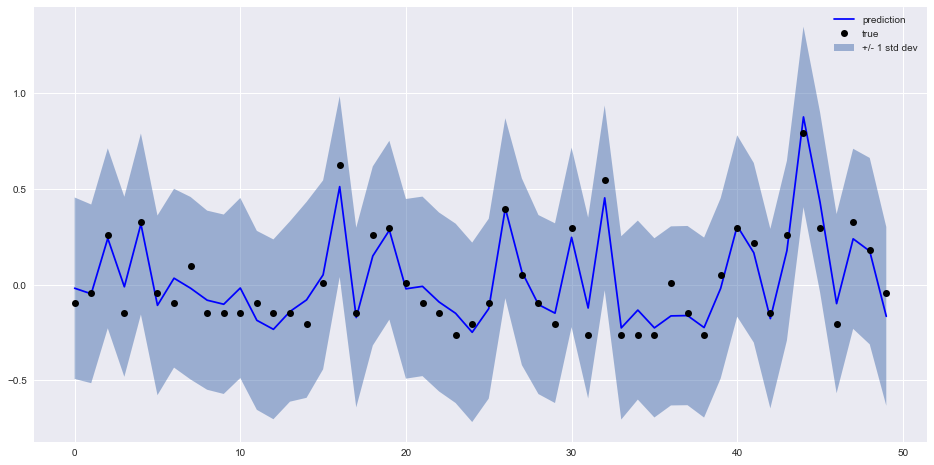

In [48]:
fig, ax = plt.subplots(figsize=(16, 8))
x_vec = np.arange(50)
ax.fill_between(x_vec, y_pred - y_std, y_pred + y_std, alpha=0.5, label='+/- 1 std dev')
ax.plot(x_vec, y_pred, 'r', label='prediction', color='blue')
ax.plot(x_vec, y_valid[:50], 'ko', label='true')
ax.legend();

# Classification

GPs are most frequently used for regression, but it's possible to use them for classification as well. Since the output distribution cannot be a Gaussian in case of classification, we cannot use exact GPs for this. Instead, we again rely on variational GPs.

## Binary classification

For binary classification, we can use skorch's `GPBinaryClassifier`, which uses `gpytorch.likelihoods.BernoulliLikelihood` by default. Bernoulli distributions can be used to model binary outcomes, which is exactly what we're interested in.

This section is loosely based on the following GPyTorch tutorial:

https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/Non_Gaussian_Likelihoods.html

### Getting the data

Again, we will rely on a toy dataset based on the sine function with added noise for this section. However, instead of defining a regression target, we transform the target into a classification problem by assigning the label 1 to positive targets and 0 to negative targets.

In [49]:
sampling_frequency = 2
X_train = torch.arange(-8, 9, 1 / sampling_frequency).float()
y_train = torch.sin(X_train) + 0.5 * torch.rand(len(X_train)) - 0.25
y_train = (y_train > 0).long()

In [50]:
X_valid = torch.linspace(-10, 10, 100)
y_valid = (torch.sin(X_valid) > 0).long()

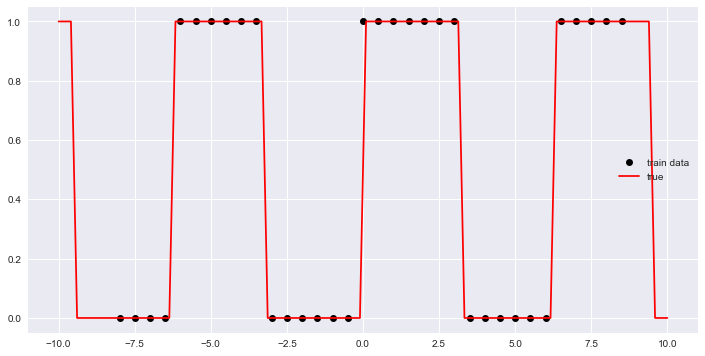

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, color='red', label='true')
ax.legend()

### Defining the module

In [52]:
from gpytorch.variational import UnwhitenedVariationalStrategy

As in the previous example using variational GP, we need to define a variational strategy for our module.

In [53]:
class GPClassificationModule(ApproximateGP):
    def __init__(self, X):
        variational_distribution = CholeskyVariationalDistribution(X.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, X, variational_distribution, learn_inducing_locations=False,
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

### Defining the GPBinaryClassifier

In [54]:
from skorch.probabilistic import GPBinaryClassifier

This time around, instead of using skorch's `GPRegressor`, we will use `GPBinaryClassifier`. The rest is pretty much the same as above. As inducing points, we use the whole training dataset, since it's only so small. For bigger datasets, you might want to choose a subset.

In [55]:
gpc = GPBinaryClassifier(
    GPClassificationModule,
    module__X=X_train if DEVICE == 'cpu' else X_train.cuda(),
    criterion__num_data=len(X_train),

    optimizer=torch.optim.Adam,
    lr=0.01,
    max_epochs=30,
    device=DEVICE,
)

### Fitting

For classification, `GPBinaryClassifier` performs an internal, stratified train/validation split, as usual for skorch.

In [56]:
gpc.fit(X_train, y_train)

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.4074        0.9081       0.5714        1.0286  0.0173
      2       1.0000        1.0126       0.5714        0.9833  0.0223
      3       1.0000        0.9556       0.5714        0.9711  0.0181
      4       1.0000        0.9351       0.5714        0.9713  0.0189
      5       1.0000        0.9268       0.5714        0.9713  0.0219
      6       1.0000        0.9180       0.5714        0.9557  0.0189
      7       1.0000        0.8939       0.5714        0.9376  0.0233
      8       1.0000        0.8674       0.5714        0.9350  0.0159
      9       1.0000        0.8564       0.5714        0.9442  0.0202
     10       1.0000        0.8573       0.5714        0.9483  0.0229
     11       1.0000        0.8531       0.5714        0.9420  0.0258
     12       1.0000        0.8385       0.5714        0.9340  0.0301
     13       1.0000

<class 'skorch.probabilistic.GPBinaryClassifier'>[initialized](
  module_=GPClassificationModule(
    (variational_strategy): UnwhitenedVariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
  ),
)

### Analyzing the trained model

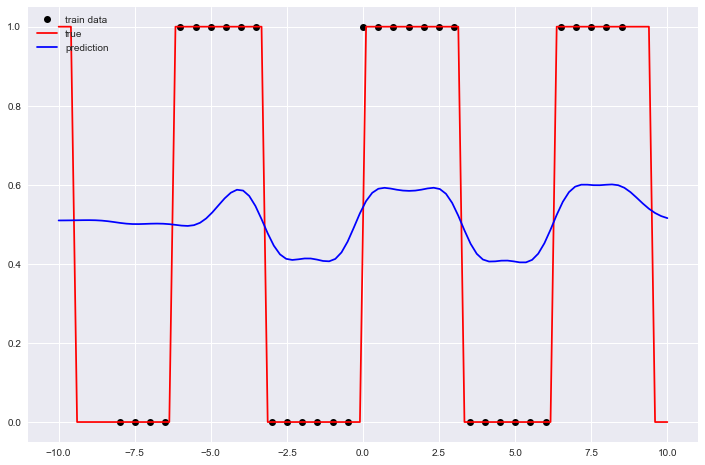

In [57]:
y_proba = gpc.predict_proba(X_valid)
y_proba = y_proba[:, 1]  # take probability for class=1
y_pred = gpc.predict(X_valid)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, y_train, 'ko', label='train data')
ax.plot(X_valid, y_valid, color='red', label='true')
ax.plot(X_valid, y_proba, color='blue', label='prediction')
ax.legend()

Here are the accuracy scores and training and validation data:

In [58]:
gpc.score(X_train, y_train)

0.8235294117647058

In [59]:
gpc.score(X_valid, y_valid)

0.76

As you can see, the model performs reasonably on the dataset but the probabilities are fairly close to 0.5. Other kinds of models might do better.

## Multiclass Classification

Currently, skorch does not directly support multiclass classification. We can still get there, however, by using sklearn's [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) with `GPBinaryClassifier`.

In [60]:
from sklearn.multiclass import OneVsRestClassifier

### Getting the data

Here we use a synthetic multiclass classification dataset provided by sklearn.

In [61]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [62]:
X, y = make_classification(n_informative=10, n_classes=5, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

### Defining the model

We use the same module as previously and again define a `GPBinaryClassifier`. We set `verbose=0` to not get flooded by print outputs, and we set `train_split=False` since we're not interested in internal validation scores.

In [63]:
gpc = GPBinaryClassifier(
    GPClassificationModule,
    # explicit conversion to torch tensor necessary
    module__X=torch.as_tensor(X_train) if DEVICE == 'cpu' else orch.as_tensor(X_train).cuda(),
    criterion__num_data=len(X_train),

    optimizer=torch.optim.Adam,
    lr=0.05,
    max_epochs=200,
    verbose=0,
    train_split=False,
    device=DEVICE,
)

Next we wrap our binary classifier inside sklearn's `OneVsRestClassifier`.

In [64]:
clf = OneVsRestClassifier(gpc)

### Fitting

In [65]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=<class 'skorch.probabilistic.GPBinaryClassifier'>[uninitialized](
  module=<class '__main__.GPClassificationModule'>,
  module__X=tensor([[ 1.8401, -1.4475,  0.2814,  ...,  0.4767,  0.1761,  1.0107],
          [-2.8451,  2.4627,  0.8404,  ..., -0.8345, -1.9006,  1.2136],
          [-0.4548, -0.0118,  1.0708,  ..., -0.6810, -0.2683, -0.4301],
          ...,
          [-2.2161,  1.4446, -1.7619,  ...,  1.5913,  0.1981,  0.7221],
          [-3.5282,  0.6850,  0.5887,  ...,  0.3524,  1.0001,  1.2653],
          [-0.5764, -0.1293, -0.0389,  ...,  0.7342, -0.3047,  2.6083]]),
))

### Analyzing the trained model

Here are the accuracy scores and training and validation data:

In [66]:
clf.score(X_train, y_train)

0.9466666666666667

In [67]:
clf.score(X_valid, y_valid)

0.52

The multiclass classifier does quite well on the training data but the score on the validation data leaves something to be desired. Given that we have 5 classes, a naive model would only be 20% accurate, so the given score is markedly better than that, but it's still not spectacular.